In [1]:
import numpy as np
import pandas as pd
from random import randint
import matplotlib.pyplot as plt
import copy
from random import shuffle
import math

In [2]:
veh_N = 25
veh_cap = 200

In [3]:
data = pd.read_csv('C108.csv')

In [4]:
data[0:15]

,CUST,X,Y,DEMAND,START_T,END_T,SERVICE_T
0,0,40,50,0,0,1236,0
1,1,45,68,10,830,1049,90
2,2,45,70,30,756,939,90
3,3,42,66,10,16,336,90
4,4,42,68,10,643,866,90
5,5,42,65,10,15,226,90
6,6,40,69,20,499,824,90
7,7,40,66,20,87,308,90
8,8,38,68,20,150,429,90
9,9,38,70,10,429,710,90


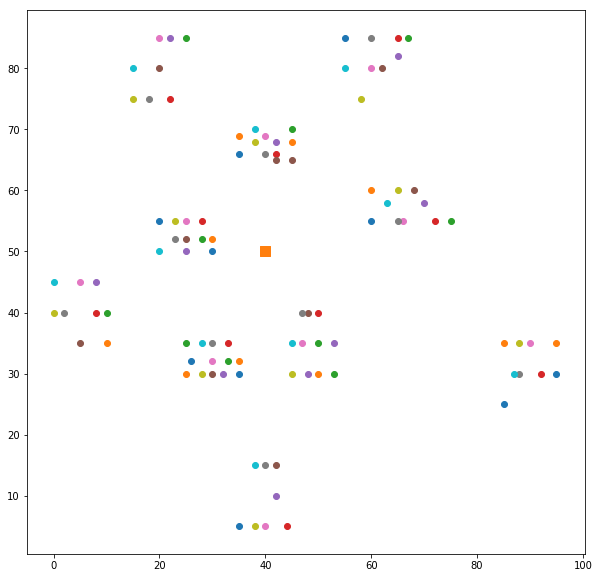

In [5]:
plt.figure(figsize=(10, 10))
for p in data.values:
    plt.scatter(p[1],p[2])
plt.scatter(data.values[0][1],data.values[0][2], marker='s',s=100 )
plt.show()

In [6]:
veh_n=veh_N

In [7]:
class Customer(object):
    def __init__(self, number, x, y, demand, start_t, end_t, service_t):
        self.number: int = number
        self.x: int = x
        self.y: int = y
        self.demand: int = demand
        self.start_t: int = start_t
        self.end_t: int = end_t
        self.service_t: int = service_t
        self.is_visited = False
    def __repr__(self):
        return f"Customer {self.number, self.x, self.y, self.demand, self.start_t, self.end_t, self.service_t, self.is_visited }"
    def distance(self, target):
        return ((self.x - target.x)**2 + (target.y - self.y)**2)**0.5
    def visited(self):
        self.is_visited = True
    def not_visited(self):
        self.is_visited = False

In [8]:
class Route(object):
    def __init__(self, depot, capacity, customs = []):
        customs.insert(0, depot)
        customs.append(depot)
        self._customers: list = customs
        self._time_of_visiting: list = [0,0]    
        self.capacity: int = capacity
        self.used = False
        self.total_distance: float = 0
    def __repr__(self):
        return f"Route {self._customers,self._time_of_visiting, self.capacity, self.used,self.total_distance }"
    
    
    def add_customer(self, customer):
        self.capacity -= customer.demand
        dist = self._customers[-2].distance(customer)
        cur_time = max(self._time_of_visiting[-2] + dist, customer.start_t) + customer.service_t 
        self.total_distance += dist+self._customers[-1].distance(customer) - self._customers[-1].distance(self._customers[-2])
        n_cust = len(self._customers)
        (self._time_of_visiting).insert(n_cust-1, cur_time)
        (self._customers).insert(n_cust-1, customer)
        (self._time_of_visiting)[n_cust] = cur_time + self._customers[-1].distance(customer)
        customer.visited()

        
    def check_customer(self, customer):
        if (self.capacity>=customer.demand):
            dist = self._customers[-2].distance(customer)
            if (self._time_of_visiting[-2] + dist <= customer.end_t):
                if ((self._time_of_visiting[-2] + dist + self._customers[-1].distance(customer) + customer.service_t) <= self._customers[-1].end_t):
                    return dist
        return False
                   
    def calculate_total_distance(self):
        dist = 0
        for i in range(len(self._customers)-1):
            dist+=(self._customers[i]).distance(self._customers[i+1])
        return dist


    def locate_customer(self, customer):
        n_cust = len(self._customers)
        best_route = copy.deepcopy(self)
        for i in range(1,n_cust):
            new_route = copy.deepcopy(self)
            cust = copy.deepcopy(new_route._customers)
            cust = cust[:i] + [customer] + cust[i:]
            new_route._customers = copy.deepcopy(cust)
            existance = is_existing(new_route) 
            if (existance):
                new_route._time_of_visiting = existance[0]
                new_route.total_distance = existance[1]
                best_route = copy.deepcopy(new_route)
                customer.visited()
        self = copy.deepcopy(best_route)
        if (customer.is_visited):
            return True
        else:
            return False

In [9]:
def is_existing(route, penalty_matr):
    route.capacity = veh_cap
    n_cust = len(route._customers)
    total_distance = 0
    cur_time = 0
    time_of_visiting = []
    penalty = 0
    for j in range(0, n_cust):
        route.capacity -= route._customers[j].demand 
        if ((cur_time <= route._customers[j].end_t) and (route.capacity>=0)):
                        cur_time = max(cur_time, route._customers[j].start_t) + route._customers[j].service_t 
                        time_of_visiting.append(cur_time)
                        if (j != n_cust - 1):
                            cur_time += route._customers[j].distance(route._customers[j+1])
                            total_distance += route._customers[j].distance(route._customers[j+1])                              
        else:
            break
    for i in range(len(route._customers)-1):
            c1 = route._customers[i]
            c2 = route._customers[i+1]
            penalty += penalty_matr[c1.number][c2.number]
    if (len(time_of_visiting) == n_cust):
        return [time_of_visiting, total_distance]
    return False

In [10]:
customers = [Customer(c[0],c[1],c[2],c[3],c[4],c[5],c[6]) for c in data.values]
routes = []
penalty_matr = [[0 for j in range(len(customers))] for i in range(len(customers))]
def initial_solution(routes):
    routes.clear()
    for i in range(len(customers)):
        customers[i].not_visited()
    for i in range(veh_n - len(routes)):
        routes.append(Route(customers[0], veh_cap,[]))

    customers[0].visited()
    customers.sort(key = lambda x: x.start_t)
    for c in customers:
        if (c.is_visited):
            continue
        min_dist=1000000
        suitable_route = None
        for i in range(veh_n):
            dist = routes[i].check_customer(c)
            if ((dist!=False) and (dist<=min_dist)):
                min_dist=dist
                suitable_route = i
        if (suitable_route != None):
            routes[suitable_route].add_customer(c)
    unvisited_customers = ([c for c in customers if (c.is_visited == False)])
    for c in unvisited_customers:
        for r in routes:
            if (r.locate_customer(c) == True):
                break
    return routes

def plot_routes(routes):
    plt.figure(figsize=(10, 10))
    for c in customers:
        plt.scatter(c.x,c.y, c="black")
    for r in routes:
        plt.plot([customer.x for customer in r._customers],[customer.y for customer in r._customers])

    plt.scatter(data.values[0][1],data.values[0][2], marker='s',s=100 )
    plt.show()
    print(sum([r.total_distance for r in routes]))

In [11]:
def two_opt(route, penalty_matr):
    n_cust = len(route._customers)
    new_route = copy.deepcopy(route)
    best_route = copy.deepcopy(route)
    cust = copy.deepcopy(route._customers)
    if (n_cust<5):
        return best_route
    for i in range(n_cust-3):
        for j in range(i+2,n_cust-1):
            a = cust[:i+1]+ cust[i+1:j+1][::-1]+ cust[j+1::]     
            new_route._customers = copy.deepcopy(a)  
            existance = is_existing(new_route, penalty_matr)
            if (existance):
                if (existance[1] < best_route.total_distance):
                    new_route._time_of_visiting = existance[0]
                    new_route.total_distance = existance[1]
                    best_route = copy.deepcopy(new_route)
    return copy.deepcopy(best_route)

def move_locate(route, penalty_matr):
    n_cust = len(route._customers)
    best_route = copy.deepcopy(route)
    new_route = copy.deepcopy(route)
    cust = copy.deepcopy(route._customers)
    if (n_cust>2):
        for i in range(1,n_cust-2):
            for j in range(i+1,n_cust-1):
                new_route = copy.deepcopy(best_route)
                new_route._customers[i] = copy.deepcopy(best_route._customers[j])
                new_route._customers[j] = copy.deepcopy(best_route._customers[i])
                existance = is_existing(new_route, penalty_matr)

                if (existance):
                    if (existance[1] < best_route.total_distance):
                        new_route._time_of_visiting = existance[0]
                        new_route.total_distance = existance[1]
                        best_route = copy.deepcopy(new_route)
    return copy.deepcopy(best_route)

In [12]:
def swap(route0,route1, penalty_matr):
    n =[len(route0._customers), len(route1._customers)]
    new_route = [copy.deepcopy(route0),copy.deepcopy(route1)]
    best_route = [copy.deepcopy(route0),copy.deepcopy(route1)]
    cust = [copy.deepcopy(route0._customers), copy.deepcopy(route1._customers)]
    for i in range(1, n[0]-1):
        for j in range(1, n[1]-1):
            a1 = cust[0][:i] + [cust[1][j]] + cust[0][i+1:]
            a2 = cust[1][:j] + [cust[0][i]] + cust[1][j+1:]
            new_route[0]._customers = a1
            new_route[1]._customers = a2 
            existance0 = is_existing(new_route[0], penalty_matr)
            if (existance0):
                existance1 = is_existing(new_route[1], penalty_matr)
                if (existance1):
                    if (existance0[1]+existance1[1] < best_route[0].total_distance + best_route[1].total_distance):
                        new_route[0]._time_of_visiting = existance0[0]
                        new_route[0].total_distance = existance0[1]
                        new_route[1]._time_of_visiting = existance1[0]
                        new_route[1].total_distance = existance1[1]
                        best_route = copy.deepcopy(new_route)
    return copy.deepcopy(best_route)    

def cross(route0,route1, penalty_matr):
    n =[len(route0._customers), len(route1._customers)]
    new_route = [copy.deepcopy(route0),copy.deepcopy(route1)]
    best_route = [copy.deepcopy(route0),copy.deepcopy(route1)]
    cust = [copy.deepcopy(route0._customers), copy.deepcopy(route1._customers)]
    for i in range(1, n[0]-1):
        for j in range(1, n[1]-1):
            a1 = cust[0][:i+1] + cust[1][j+1:]
            a2 = cust[1][:j+1] + cust[0][i+1:]
            new_route[0]._customers = a1
            new_route[1]._customers = a2 
            existance0 = is_existing(new_route[0], penalty_matr)
            if (existance0):
                existance1 = is_existing(new_route[1], penalty_matr)
                if (existance1):
                    if (existance0[1]+existance1[1] < best_route[0].total_distance + best_route[1].total_distance):
                        new_route[0]._time_of_visiting = existance0[0]
                        new_route[0].total_distance = existance0[1]
                        new_route[1]._time_of_visiting = existance1[0]
                        new_route[1].total_distance = existance1[1]
                        best_route = copy.deepcopy(new_route)
    return copy.deepcopy(best_route)  

In [13]:
def local_search(routes, penalty_matr):
    plot_routes(routes)
    old_sum  = 1000000
    step = 0
    current_sum = sum([r.total_distance for r in routes])
    while old_sum - current_sum > 0.1: 
        old_sum = copy.deepcopy(current_sum)
        for i in range(len(routes)-1):
            for j in range(i+1, len(routes)):
                br = swap(routes[i], routes[j], penalty_matr)
                routes[i] = copy.deepcopy(br[0])
                routes[j] = copy.deepcopy(br[1])
                br = cross(routes[i], routes[j], penalty_matr)
                routes[i] = copy.deepcopy(br[0])
                routes[j] = copy.deepcopy(br[1])
        for i in range(len(routes)):
            routes[i] = two_opt(routes[i], penalty_matr)
            routes[i] = move_locate(routes[i], penalty_matr)
        current_sum = sum([r.total_distance for r in routes])
        step +=1
        print("STEP:{} \nCS:{}".format(step, current_sum))
    return routes

In [14]:
def nice_view(routes,name):
    file = open(name, 'w+')
    result = []
    for r in routes:
        cur_time = 0
        if (len(r._customers)>2):
            res = str(0) + ' ' + str(0)
            for j in range(1, len(r._customers)):
                dist = r._customers[j-1].distance(r._customers[j]) 
                vt = max(cur_time+dist, r._customers[j].start_t)
                res = res +' ' + (str(r._customers[j].number) + ' ' + str(vt)  )
            file.write(res + "\n")
    file.close()
    total_file = open('VRP_total.txt', 'a+')
    total_file.write(name[:-3] + ' ' + str(sum([r.total_distance for r in routes]))+ "\n")
    total_file.close()
        

## GUIDED LOCAL SEARCH

In [15]:
def matr_dist(customers):
    matr = []
    for i in customers:
        m = []
        for j in customers:
            m.append(j.distance(i))
        matr.append(m)
    return matr

In [16]:
def matr_edges(routes, customers):
    matr = [[0 for j in range(len(customers))] for i in range(len(customers))]
    for r in routes:
        for i in range(len(r._customers)-1):
            c1 = r._customers[i]
            c2 = r._customers[i+1]
            matr[c1.number][c2.number] = 1
            matr[c2.number][c1.number]= 1 
    return matr
                
            

In [18]:
def recalculate_tot_dist_with_penalty(routes, penalty_matr):
    for r in routes:
        for i in range(len(r._customers)-1):
            c1 = r._customers[i]
            c2 = r._customers[i+1]
            r.total_distance += lamb * penalty_matr[c1.number][c2.number]

In [19]:
lamb = 0.5
def GLS(routes,customers):
    lamb = 0.25
    routes = initial_solution(routes)
    plot_routes(routes)
    penalty_matr = [[0 for j in range(len(customers))] for i in range(len(customers))]
    recalculate_tot_dist_with_penalty(routes, penalty_matr)
    dist = matr_dist(customers)
    
    for step in range(5):
        routes = local_search(routes, penalty_matr)
        m_edges = matr_edges(routes,customers)
        utility = [[m_edges[x][y] * dist[x][y]/(1 + penalty_matr[x][y]) for x in range(len(customers))] for y in range(len(customers))]
        
        max_ut = [max(u) for u in utility]
        
        for i in range(len(utility)):
            for j in range(len(utility[i])):
                if utility[i][j] == max_ut:
                    penalty_matr[i][j] += 1
return routes
    

[]

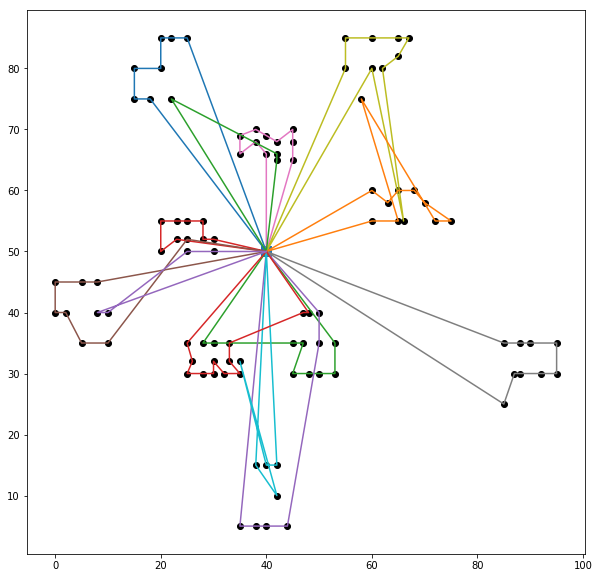

1194.7617191072661


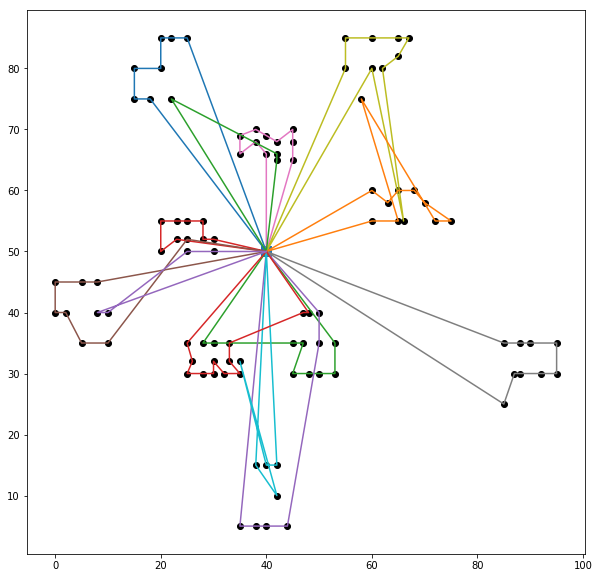

1194.7617191072661
STEP:1 
CS:1062.666986204984
STEP:2 
CS:1056.870204163131
STEP:3 
CS:1055.819910540861
STEP:4 
CS:1054.0520816052285
STEP:5 
CS:1054.0520816052285


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [48]:
routes = GLS(routes,customers)